In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

## Option Pricing Using Binomial Lattice

Here we will the python code for pricing European and American Options of both put and call, using a binomial lattice.

In [2]:
def opt_price_bin(sigma, r, T, K, SO, Nsteps, style, opttype):
    # sigma - volatility; r - interest rate; T - expiry time; K - strike
    # S0 - current stock price; Nsteps - the number of timesteps
    # style - 0 for American and 1 for European; opttype - 0 for a call and 1 for a put 
    
    delt = T/Nsteps
    # tree parameters 
    u = np.exp(sigma * np.sqrt(delt))
    d = 1./u
    a = np.exp(r*delt)
    p = (a - d)/(u - d)
    q = 1 - p
    
    # payoff at t=T (all S^T)
    # here reperesents all the S_j at t=T
    W = SO * d**(np.arange(Nsteps,-1,-1)) * u**(np.arange(Nsteps+1)) # All down case to All up case
    S = W # Second column stored for American Style payoffs as option value = max payoff at t=T

    # W is column vector of length Nsteps+1 - for option value
    if opttype == 0:
        W = np.maximum(W - K, 0)
    else:
        W = np.maximum(K - W, 0)
           
    for i in np.arange(Nsteps,0,-1):
        W = np.exp(-r*delt)*(p*W[1:i+1] + q*W[0:i])  
        if style == 0:
            if opttype == 0: ## American Type
                S2 = S[1:]*d
                W = np.maximum(W, S - K,np.zeros(i))
            else: 
                S = S[1:]*d
                W = np.maximum(W, K - S,np.zeros(i))
    return W[0]  

**Example**

For instance, lets consider the following parameters:

$\sigma$ = 0.4

$r = 0.05$

$T = 1.2$ (in years)

$K = \$100$

$S^0_0 = \$100$

$Nsteps = 8000$ the number of timesteps we would like to take in a finite time period

$style = 1$ European Option

$opttype = 1$ A put Option


In [5]:
opt_price_bin(0.4, 0.05, 1.2, 100, 100, 8000, 1, 1)

14.07970511733452

## Warrant Pricing

Overview:

A warrant is a call option which gives the holder the right ot pay the strike price and receive shares. Here we define:

$K$ = strike

$T$ = expiry time

$\sigma$ = volatility 

$r$ = risk free rate 

$M$ = number of outstanding warrants

$N$ = number of original shares outstanding

$S_0$ = share price 

$C(S_0,K,r,T,\sigma)$ = value of a European Call Option

Then the price of a warrant, is given by (denote price as $W$):

$W$ = $\left(\frac{N}{N+M}\right)C(S_0+\frac{M}{N}W,K,r,T,\sigma)$

In [3]:
from scipy.stats import norm
import numpy as np
    
def blsprice(Price, Strike, Rate, Time, Volatility):
    sigma_sqrtT = Volatility * np.sqrt (Time)

    d1 = 1 / sigma_sqrtT * (np.log(Price / Strike) + (Rate + Volatility**2 / 2) * Time)
    d2 = d1 - sigma_sqrtT

    phi1 = norm.cdf(d1)
    phi2 = norm.cdf(d2)
    disc = np.exp (-Rate * Time)
    F    = Price * np.exp ((Rate) * Time)

    Call = disc * (F * phi1 - Strike * phi2)
    Put  = disc * (Strike * (1 - phi2) + F * (phi1 - 1))
    return Call, Put
    
def blsdelta(Price, Strike, Rate, Time, Volatility):
    d1 = 1 / (Volatility * np.sqrt(Time)) * (np.log (Price / Strike) + (Rate + Volatility**2 / 2) * Time)

    phi = norm.cdf(d1)

    CallDelta = phi
    PutDelta = phi - 1
    return CallDelta, PutDelta

Using a fixed point iteration scheme and the blsprice function adapted from Octave's financial toolkit, we will evalute the value of a European call option (as defined above).

Since we are using a fixed point iteration scheme, we set the condition to stop iteration is chosen to be

$|W^{k+1} - W^k| < 10^{-1}$ and we begin with $W_0 = 0$.

Moreover, we will provide the residual, denoted as $R^k$ where it measures how far our equation is from being satisfied, at the step k:

$R^k = W^k - \left(\frac{N}{N+M}\right) C(S_0 +\frac{M}{N}W^k,K,r,T,\sigma)$

For readability, we will provide the ouput as a table for comparison:

In [7]:
def table(Wvec,Rvec):
    print("Step Number k \t     W_k     \t   R_k")
    for i in range(len(Wvec)):
        print("    %d\t        %0.7f    \t%0.7f" % (i, Wvec[i],Rvec[i]))

In [8]:
def fixpoint_warrant(sigma,r,T,K,S0,N,M):
    # vector to store Wk given W0 = 0
    W = np.zeros(1)
    # Calculate 1 step Warrant price
    # Get European Call option - index 0
    W1 = (N/(N+M)) * blsprice(S0 + (M/N)*W[0], K,r,T,sigma)[0]
    W = np.append(W,W1) # update Wk vector
    # Next initiate vector for R0 and calculate R1
    R = np.zeros(1)
    R1 = W1 - (N/(N+M)) * blsprice(S0 + (M/N)*W1, K,r,T,sigma)[0]
    R = np.append(R,R1) # update Rk vector
    # keep record of kth-step for iteration purposes
    k_step = 1
    # Condition to stop iterating
    while (abs(W[k_step] - W[k_step-1]) >= 10e-08):       
        # Find next Wk
        curr_W = (N/(N+M)) * blsprice(S0 + (M/N)*W[k_step], K,r,T,sigma)[0]
        # Find next Rk
        curr_R = curr_W - (N/(N+M)) * blsprice(S0 + (M/N)*curr_W, K,r,T,sigma)[0]
        # update both Wk and Rk vector
        W = np.append(W,curr_W)
        R = np.append(R,curr_R)
        # update k-step - iteration
        k_step += 1 
    return table(W,R)

**Example:**

For instance, lets consider the following parameters:

$\sigma = 0.4$

$r = 0.04$

$T = 2$ (in years)

$K = \$100$

$S_0 = \$100$

$N = 30 \times 10^6$

$M = 7 \times 10^7$

In [10]:
fixpoint_warrant(sigma = 0.4,r = 0.04 ,T = 2,K = 100,S0 = 100,N = 30*10**6,M = 7*10**7)

Step Number k 	     W_k     	   R_k
    0	        0.0000000    	0.0000000
    1	        7.6399015    	-3.8295285
    2	        11.4694301    	-2.0963971
    3	        13.5658271    	-1.1882954
    4	        14.7541225    	-0.6850046
    5	        15.4391271    	-0.3984160
    6	        15.8375431    	-0.2328778
    7	        16.0704209    	-0.1365026
    8	        16.2069235    	-0.0801417
    9	        16.2870652    	-0.0470962
    10	        16.3341614    	-0.0276919
    11	        16.3618533    	-0.0162877
    12	        16.3781411    	-0.0095819
    13	        16.3877229    	-0.0056375
    14	        16.3933605    	-0.0033171
    15	        16.3966776    	-0.0019518
    16	        16.3986294    	-0.0011485
    17	        16.3997779    	-0.0006758
    18	        16.4004537    	-0.0003977
    19	        16.4008514    	-0.0002340
    20	        16.4010854    	-0.0001377
    21	        16.4012231    	-0.0000810
    22	        16.4013041    	-0.0000477
    23	        16.4013518    	-0.0

## Delta Hedging

Here we will be looking at a discrete delta hedgeing consisting of a portfolio $\prod(t)$ compromised of components:

- Short option position:$-V(S(t),t)$

- Long $\alpha(t)$ shares at price $S(t)

- An amount in a risk-free bank account $B(t)$

Given at a intial starting point, we have:

$\prod(0) = -V(S(0),0) + \alpha(0)S(0) + B(0) = 0$

$\alpha(0) = \frac{\partial V}{\partial S}(S(0),0)$

$B(0) = V(S(0),0) - \alpha(0)S(0)$

At a discrete time $t_i$, the hedge is rebalanced by:

$\alpha_i = \frac{\partial V}{\partial S}(S_i,t_i)$

$V_i = V(S_i,t_i)$

Updating the hedge by purchasing $\alpha_i - \alpha_{i-1}$ shares at $t=t_i$, so when updating our share position requres $S(t_i)(\alpha_i - \alpha_{i-1})$ in cash (borrowed from the bank). Thus, the rebalancing at time $t_i$ provides a portfolio value of:

$\prod_i = -V_i +\alpha_iS_i + B_i$

Moreover, we will be produce plots, to provide a visualized on how as we increase the number of hedging rebalances is a fixed period of time, to highlight the sophication and the general trends between our risk free account (bank) and our stock holding. In short, this will be done through simulating a stochastic path of a delta hedge. 

We will also be looking at hte Relative Hedge Error at expiry time $t=T$, given by:

RHE = $\frac{e^{-rT}\prod(T)}{|V(0)|}$

**To note:** We will be evolving the stock price $S$ under the assumption of Geometric Brownian Motion (GBM) by:

$S(t_{i+1}) = S(t_i)exp[(\mu-\sigma^2/2)(t_{i+1}-t_i)+\sigma\phi\sqrt{t_{i+1}-t_i})]$ ; where $\phi \sim N(0,1)$

In [15]:
# set a seed
np.random.seed(100)
## Delta Hedge function
# HRB is the specified number of discrete hedging rebalances
def DH(HRB, sigma, r, T, K, S0, mu, PT):
    # Starting at t = 0, we have:
    S = [S0]
    V = [blsprice(S0, K, r, T, sigma)[PT]] # Put option
    Alpha = [blsdelta(S0, K, r, T, sigma)[PT]]
    B = [V[0] - Alpha[0] * S[0]]
    port_val = [-V[0] + Alpha[0] * S[0] + B[0]]
    t = [0] # no rebalacing at 0 and T
    sigma2 = sigma**2
    delt = T/(HRB+1)
    for i in np.arange(1,HRB+2):
        # Get the next time by adding delt to the last
        t.append(t[i-1]+delt)
        sigma_rand_tdiff = sigma * np.random.randn() * math.sqrt(delt)
        # Calculate S with GBM
        S.append(S[i-1]*math.exp((mu - sigma2/2) * delt + sigma_rand_tdiff))
        # Here is the last interval [T - Δt, T]
        if i == HRB+1:
            t[i] = T
            payoff = max(K - S[-1], 0) 
            V.append(payoff) # At time T, V is the payoff
            Alpha.append(Alpha[-1]) # Alpha remains the same
            B.append(B[-1]*math.exp(r*delt)) # B earns interest
        else: # Rebalancing 
            # V evolves as usual
            V.append(blsprice(S[i], K, r, T - t[i], sigma)[PT])
            # Interest paid
            b = B[i-1]*math.exp(r*delt)
            # Update Alpha
            Alpha.append(blsdelta(S[i], K, r, T - t[i], sigma)[PT])
            # Update B
            B.append(b - S[i]*(Alpha[i] - Alpha[i-1]))
        # Update port_val
        port_val.append(-V[i] + Alpha[i] * S[i] + B[i])
    # Calculate the Relative Hedge Error
    V0 = blsprice(S0, K, r, T, sigma)[PT]
    RHE = (math.exp(-r*T)*port_val[-1])/abs(V0)
    return S, B, Alpha, port_val, RHE, t

**Example**

For instance, lets consider the following parameters for our delta hedge function: 

allHRB = [10,100,1000,10000] for simplicity lets evaluate these four numbers of discrete hedges rebalances

$\sigma$ = 0.2

$r$ = 0.05

$T$ = 1.5 (in years)

$K$ = $100  Strike price

$S_0$ = $100  initial price

$\mu$ = 0.09  our real world drift rate

$PT$ = 1$ our payoff type 0 for call and 1 for put

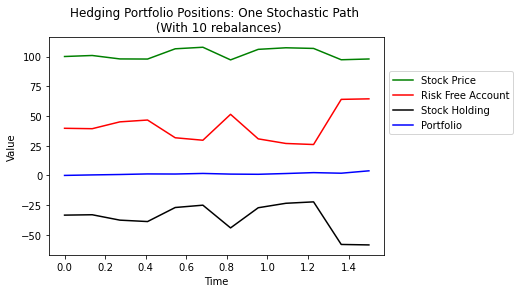

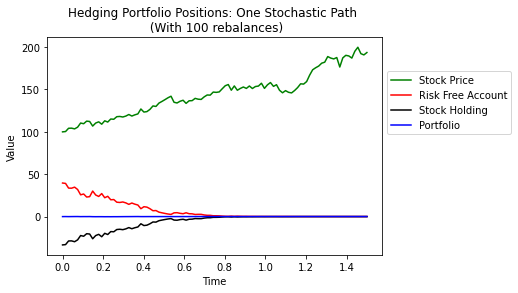

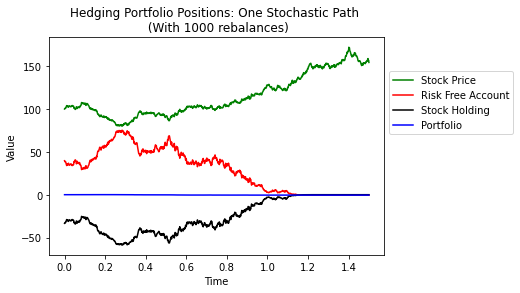

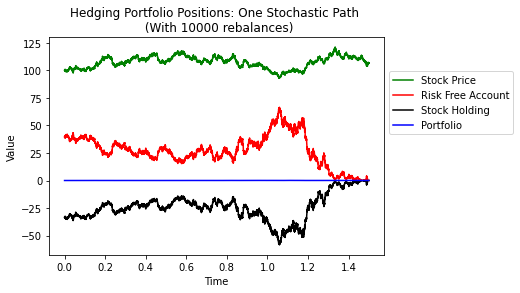

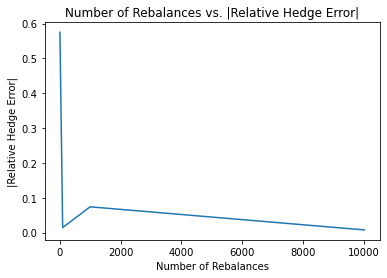

In [19]:
# Now to generate all the plots showing
# S, B, SH, and port_val -> (SH = S*Alpha)
allHRB = [10,100,1000,10000]
abs_RHS = [] # absolute value of the relative hedge error
for specHRB in allHRB:
    values = DH(specHRB, sigma = 0.2, r=0.05, T=1.5, K=100, S0=100, mu=0.09, PT=1)
    S = values[0]
    B = values[1]
    Alpha = values[2]
    SH = [a * b for a, b in zip(S,Alpha)]
    port_val = values[3]
    abs_RHS.append(abs(values[4]))
    t = values[5]
    plt.plot(t, S, color = 'green', label = 'Stock Price')
    plt.plot(t, B, color = 'red', label = 'Risk Free Account')
    plt.plot(t, SH, color = 'black', label = 'Stock Holding')
    plt.plot(t, port_val, color= 'blue', label = 'Portfolio')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Hedging Portfolio Positions: One Stochastic Path \n (With {} rebalances)'.format(specHRB))
    plt.legend(bbox_to_anchor=(1.4, 0.7), loc='center right')
    plt.show()

# Plot Number of Rebalances vs. |Relative Hedge Error|
plt.plot(allHRB, abs_RHS)
plt.xlabel('Number of Rebalances')
plt.ylabel('|Relative Hedge Error|')
plt.title('Number of Rebalances vs. |Relative Hedge Error|')
plt.show()